### Eksploracyjna analiza danych wybranego zbioru
##### Autorzy: Kacper Krzyżniewski, Dominik Ossowski

Dataset: https://www.kaggle.com/datasets/andrewmvd/handgun-detection  

---

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import re

     --------------------------------------- 38.2/38.2 MB 29.7 MB/s eta 0:00:00


---
### 1. Load and display exemplary images

In [6]:
# Path Constants
DATASET_IMAGES_PATH = '.\\data\\dataset01\\Images\\'
DATASET_LABELS_PATH = '.\\data\\dataset01\\Labels\\'

In [7]:
# Create a list of all the images and labels in the dataset
images_df = pd.DataFrame({'image_name': os.listdir(DATASET_IMAGES_PATH)})
labels_df = pd.DataFrame({'label_name': os.listdir(DATASET_LABELS_PATH)})

In [8]:
images_df.head()

image_name
0     1.jpeg
1    10.jpeg
2   100.jpeg
3   101.jpeg
4   102.jpeg

In [9]:
labels_df.head()

label_name
0      1.txt
1     10.txt
2    100.txt
3    101.txt
4    102.txt

In [10]:
# Join the two dataframes
labeled_images_df = pd.merge(images_df, labels_df, left_index=True, right_index=True)
labeled_images_df.head()

image_name label_name
0     1.jpeg      1.txt
1    10.jpeg     10.txt
2   100.jpeg    100.txt
3   101.jpeg    101.txt
4   102.jpeg    102.txt

In [11]:
# Open the label txt file and extract the bounding box coordinates
open(DATASET_LABELS_PATH + labeled_images_df['label_name'][0], 'r').read()

'1\n76 45 146 87\n'

In [13]:
# Extract the bounding box coordinates from the label txt file
# 1\n76 45 146 87\n' -> [1, 76, 45, 46, 87]

# Columns for count and bounding boxes
labeled_images_df['count'] = np.nan
labeled_images_df['x1'] = np.nan
labeled_images_df['y1'] = np.nan
labeled_images_df['x2'] = np.nan
labeled_images_df['y2'] = np.nan

# Regex -> match numbers only
regex = re.compile(r'\d+')

for index, row in labeled_images_df.iterrows():
    label_file = open(DATASET_LABELS_PATH + row['label_name'], 'r')
    label_file_contents = label_file.read()
    label_file.close()
    
    label_file_contents = regex.findall(label_file_contents)
    label_file_contents = [int(i) for i in label_file_contents]
    
    labeled_images_df.loc[index, 'count'] = label_file_contents[0]
    labeled_images_df.loc[index, 'x1'] = label_file_contents[1]
    labeled_images_df.loc[index, 'y1'] = label_file_contents[2]
    labeled_images_df.loc[index, 'x2'] = label_file_contents[3]
    labeled_images_df.loc[index, 'y2'] = label_file_contents[4]
    
labeled_images_df.head()


image_name label_name  count     x1     y1     x2     y2
0     1.jpeg      1.txt    1.0   76.0   45.0  146.0   87.0
1    10.jpeg     10.txt    1.0  115.0  130.0  163.0  161.0
2   100.jpeg    100.txt    1.0    9.0   23.0  225.0  107.0
3   101.jpeg    101.txt    1.0  153.0   25.0  198.0   70.0
4   102.jpeg    102.txt    1.0  119.0   87.0  146.0  141.0

In [10]:
# Open 1.txt to check if the bounding box coordinates are OK
open(DATASET_LABELS_PATH + labeled_images_df['label_name'][0], 'r').read()

'1\n76 45 146 87\n'

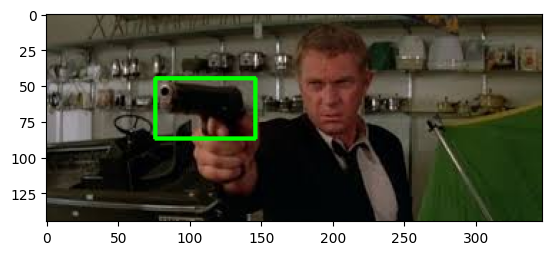

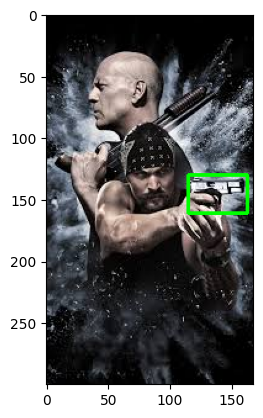

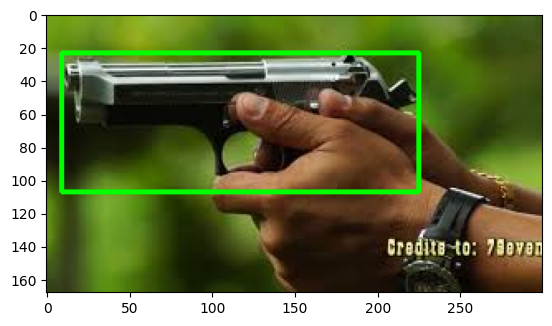

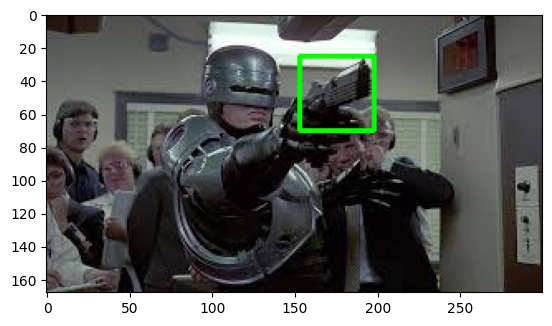

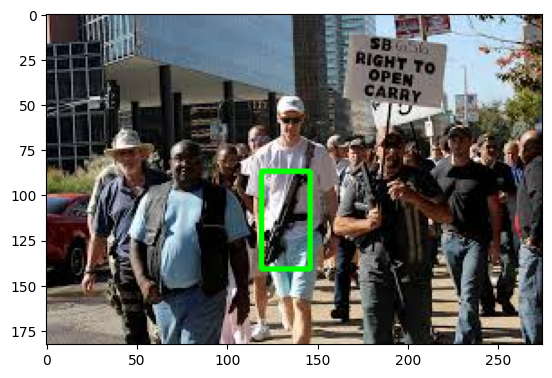

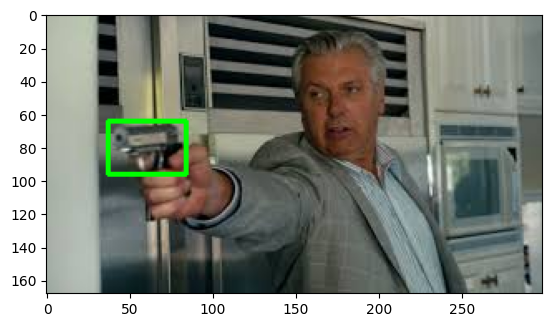

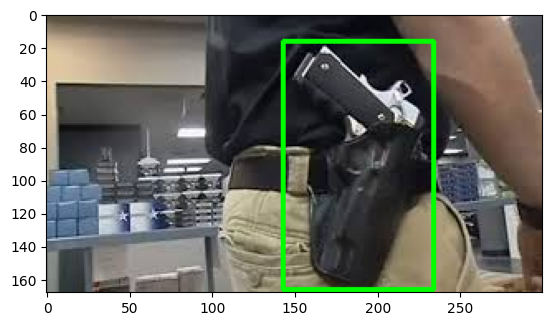

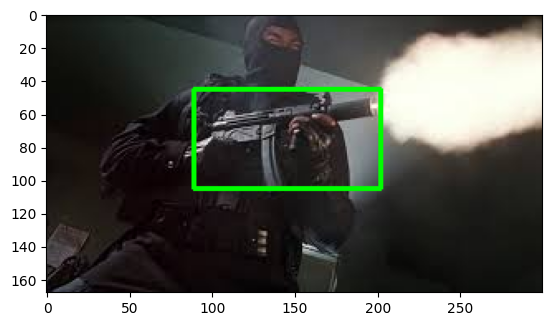

In [11]:
# Draw the bounding box on the image by its name
def draw_bounding_box(image_name):
    image = cv2.imread(DATASET_IMAGES_PATH + image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x1 = int(labeled_images_df.loc[labeled_images_df['image_name'] == image_name, 'x1'])
    y1 = int(labeled_images_df.loc[labeled_images_df['image_name'] == image_name, 'y1'])
    x2 = int(labeled_images_df.loc[labeled_images_df['image_name'] == image_name, 'x2'])
    y2 = int(labeled_images_df.loc[labeled_images_df['image_name'] == image_name, 'y2'])
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    plt.imshow(image)
    plt.show()
 
for i in range(10):
    draw_bounding_box(labeled_images_df['image_name'][i])

---
### 2. Data exploration

In [12]:
# How many images?
labeled_images_df.shape

(333, 7)

In [13]:
# Any duplicates?
labeled_images_df.duplicated().sum()

0

In [14]:
# Any NULLs?
labeled_images_df.isnull().sum()

image_name    0
label_name    0
count         0
x1            0
y1            0
x2            0
y2            0
dtype: int64

In [15]:
# Any NaNs?
labeled_images_df.isna().sum()

image_name    0
label_name    0
count         0
x1            0
y1            0
x2            0
y2            0
dtype: int64

In [16]:
# What are the distinct count values?
labeled_images_df['count'].unique()

array([ 1.,  2.,  3.,  4., 12., 11.])

In [17]:
# Print the row where count is 12
labeled_images_df.loc[labeled_images_df['count'] == 12]

image_name label_name  count     x1     y1     x2     y2
317    85.jpeg     85.txt   12.0  225.0  116.0  285.0  164.0

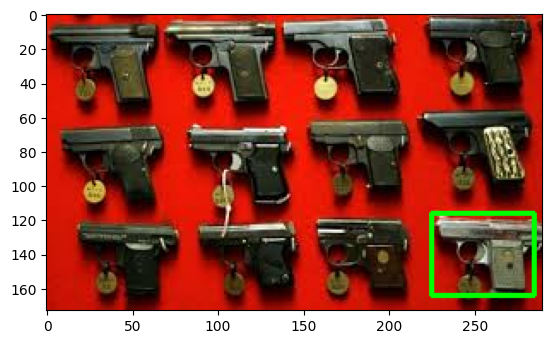

In [18]:
# Display the image with the count of 12
draw_bounding_box(labeled_images_df['image_name'][labeled_images_df['count'] == 12].values[0])

In [19]:
# Count images where count > 1
labeled_images_df.loc[labeled_images_df['count'] > 1].shape

(65, 7)

---
### 3. Image data

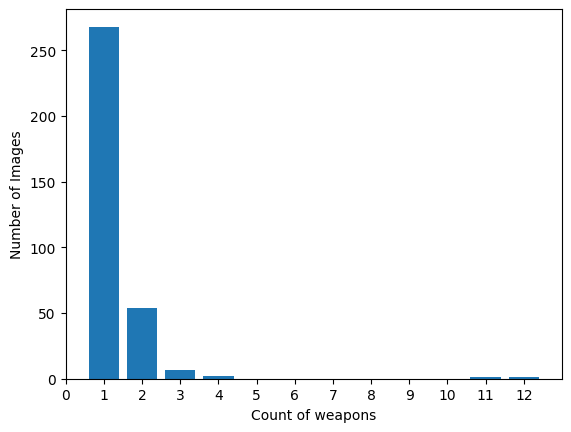

In [20]:
# Barplot of the count values
plt.bar(labeled_images_df['count'].value_counts().index, labeled_images_df['count'].value_counts().values)
plt.xticks(np.arange(0, 13, 1))
plt.xlabel('Count of weapons')
plt.ylabel('Number of Images')
plt.show()

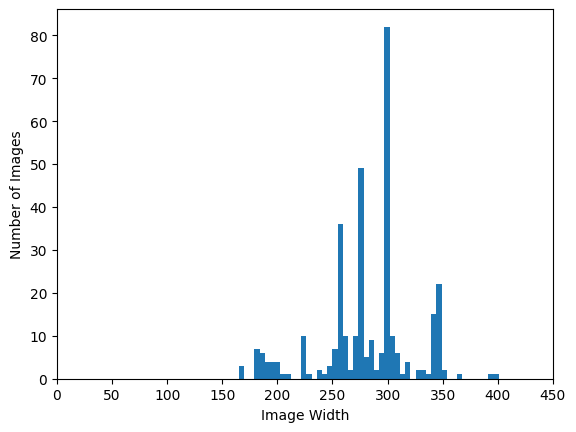

In [21]:
# Plot the distribution of widths
image_widths = np.array([])
for file in labeled_images_df['image_name']:
    image = cv2.imread(DATASET_IMAGES_PATH + file)
    image_widths = np.append(image_widths, image.shape[1])
    
plt.hist(image_widths, bins=50)
plt.xlabel('Image Width')
plt.ylabel('Number of Images')
plt.xticks(np.arange(0, 500, 50))
plt.show()

In [22]:
# Print most common width
print('Most common width: ' + str(int(np.bincount(image_widths.astype(int)).argmax())))

Most common width: 300


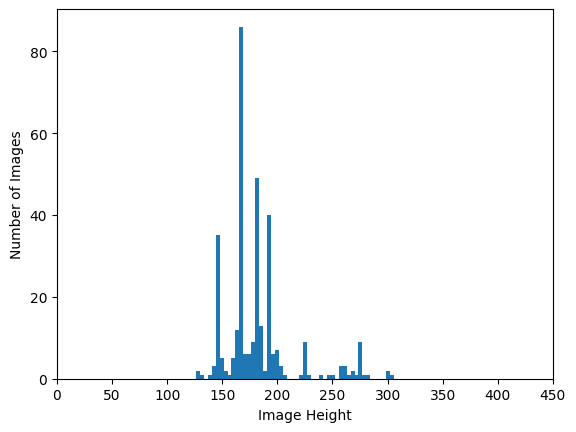

In [23]:
# Plot the distribution of heights
image_heights = np.array([])
for file in labeled_images_df['image_name']:
    image = cv2.imread(DATASET_IMAGES_PATH + file)
    image_heights = np.append(image_heights, image.shape[0])

plt.hist(image_heights, bins=50)
plt.xlabel('Image Height')
plt.ylabel('Number of Images')
plt.xticks(np.arange(0, 500, 50))
plt.show()

In [24]:
# Print most common height
print('Most common height: ' + str(int(np.bincount(image_heights.astype(int)).argmax())))

Most common height: 168


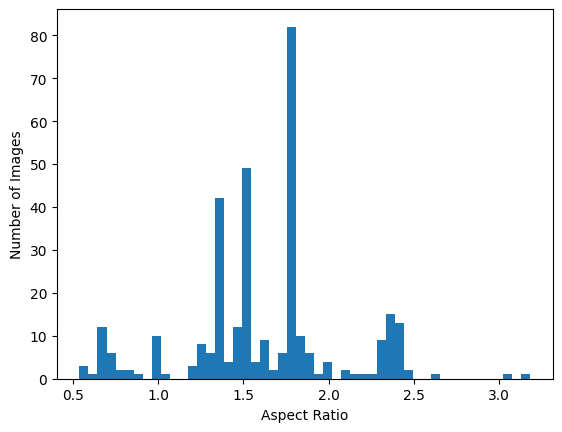

In [25]:
# Plot the distribution of aspect ratios
aspect_ratios = image_widths / image_heights
plt.hist(aspect_ratios, bins=50)
plt.xlabel('Aspect Ratio')
plt.ylabel('Number of Images')
plt.show()

---
### 4. Searching for anomalies

In [26]:
# Which files take up the most space in kilobytes?
file_sizes = np.array([])
for file in labeled_images_df['image_name']:
    file_sizes = np.append(file_sizes, os.path.getsize(DATASET_IMAGES_PATH + file) / 1024)
    
file_sizes = np.flip(np.sort(file_sizes))
file_sizes[:10]


array([16.56835938, 14.59765625, 14.46289062, 14.1796875 , 14.05957031,
       13.68359375, 13.04882812, 12.99121094, 12.87890625, 12.73925781])

In [39]:
file_sizes[-10:]

array([3.65527344, 3.63671875, 3.48339844, 3.4140625 , 3.33203125,
       3.2109375 , 3.15527344, 3.03808594, 2.75878906, 2.5078125 ])

In [28]:
# Find files with weird aspect ratios
# File is weird when aspect ratio is less than 0.5 or greater than 2
weird_files = np.array([])
for file in labeled_images_df['image_name']:
    image = cv2.imread(DATASET_IMAGES_PATH + file)
    aspect_ratio = image.shape[1] / image.shape[0]
    if aspect_ratio < 0.5 or aspect_ratio > 2:
        weird_files = np.append(weird_files, file)

weird_files.shape

(47,)

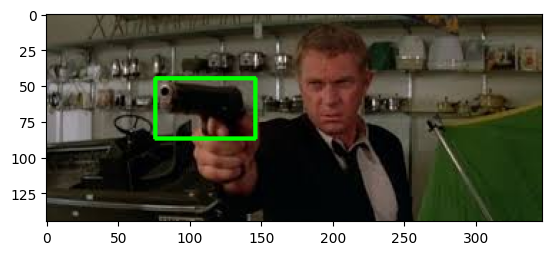

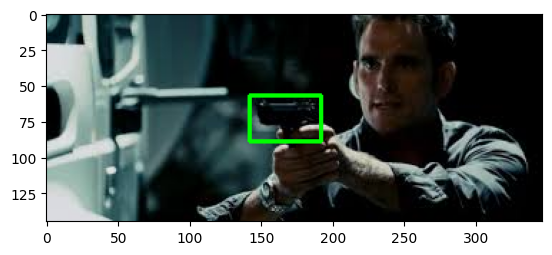

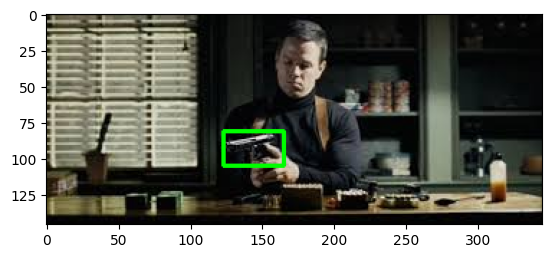

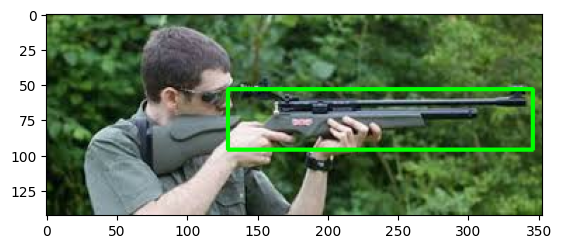

In [29]:
for i in range(5):
    draw_bounding_box(weird_files[i])


In [30]:
# Find images where bounding box is outside of the image
weird_files = np.array([])

for file in labeled_images_df['image_name']:
    image = cv2.imread(DATASET_IMAGES_PATH + file)
    x1 = int(labeled_images_df.loc[labeled_images_df['image_name'] == file, 'x1'])
    y1 = int(labeled_images_df.loc[labeled_images_df['image_name'] == file, 'y1'])
    x2 = int(labeled_images_df.loc[labeled_images_df['image_name'] == file, 'x2'])
    y2 = int(labeled_images_df.loc[labeled_images_df['image_name'] == file, 'y2'])
    if x1 < 0 or y1 < 0 or x2 > image.shape[1] or y2 > image.shape[0]:
        weird_files = np.append(weird_files, file)
        
weird_files.shape

(1,)

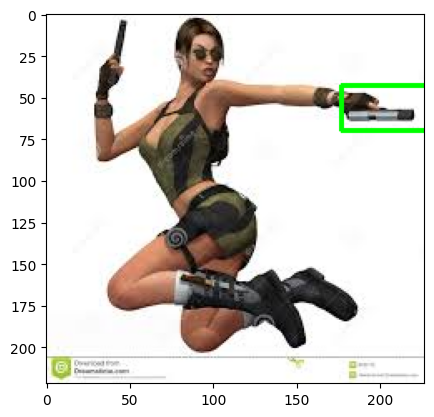

In [31]:
draw_bounding_box(weird_files[0])

In [32]:
# Find files where bounding box is too small
weird_files = np.array([])


for file in labeled_images_df['image_name']:
    image = cv2.imread(DATASET_IMAGES_PATH + file)
    x1 = int(labeled_images_df.loc[labeled_images_df['image_name'] == file, 'x1'])
    y1 = int(labeled_images_df.loc[labeled_images_df['image_name'] == file, 'y1'])
    x2 = int(labeled_images_df.loc[labeled_images_df['image_name'] == file, 'x2'])
    y2 = int(labeled_images_df.loc[labeled_images_df['image_name'] == file, 'y2'])
    if (x2 - x1) < 20 or (y2 - y1) < 20:
        weird_files = np.append(weird_files, file)

weird_files.shape

(3,)

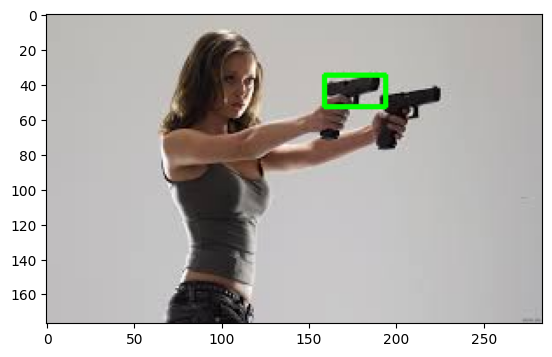

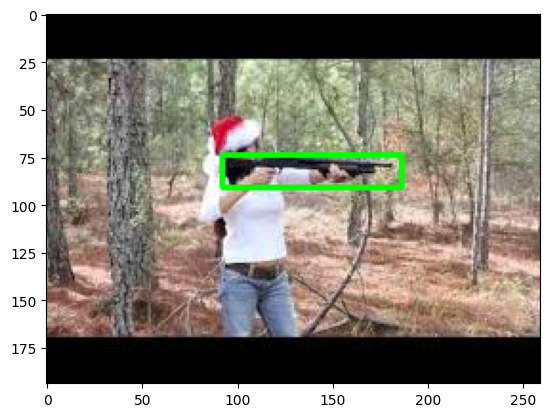

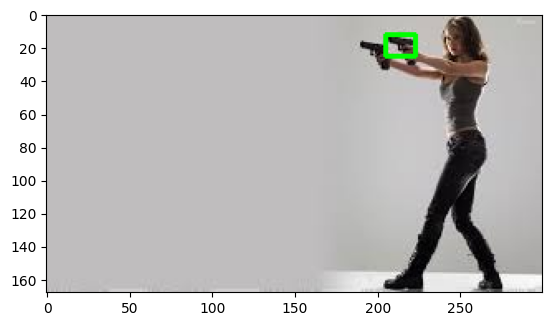

In [33]:
for i in range(weird_files.shape[0]):
    draw_bounding_box(weird_files[i])

In [34]:
# Find files where bounding box is too large
weird_files = np.array([])

for file in labeled_images_df['image_name']:
    image = cv2.imread(DATASET_IMAGES_PATH + file)
    x1 = int(labeled_images_df.loc[labeled_images_df['image_name'] == file, 'x1'])
    y1 = int(labeled_images_df.loc[labeled_images_df['image_name'] == file, 'y1'])
    x2 = int(labeled_images_df.loc[labeled_images_df['image_name'] == file, 'x2'])
    y2 = int(labeled_images_df.loc[labeled_images_df['image_name'] == file, 'y2'])
    if (x2 - x1) > 250 or (y2 - y1) > 250:
        weird_files = np.append(weird_files, file)
        
weird_files.shape

(2,)

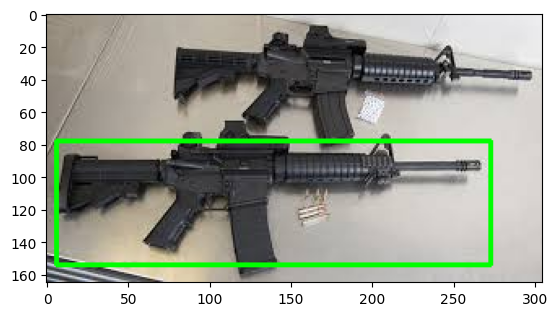

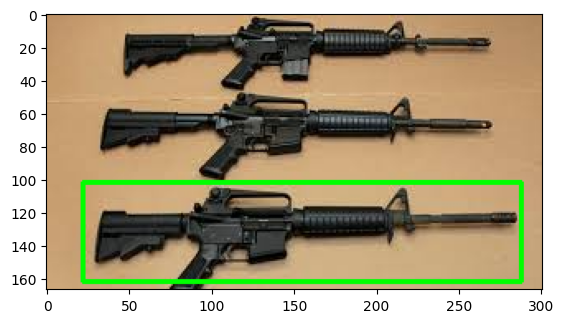

In [35]:
for i in range(weird_files.shape[0]):
    draw_bounding_box(weird_files[i])

In [36]:
# Find files with weird histogram
weird_files = np.array([])

for file in labeled_images_df['image_name']:
    image = cv2.imread(DATASET_IMAGES_PATH + file)
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    if hist[0] > 25000 or hist[255] > 25000:
        weird_files = np.append(weird_files, file)

weird_files.shape

(11,)

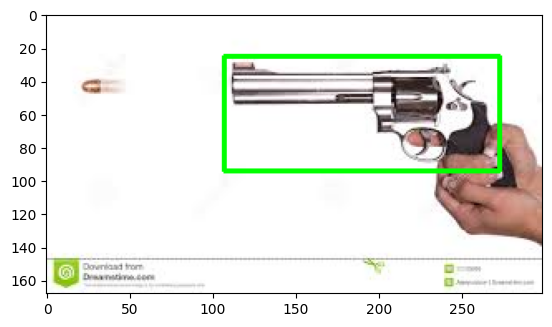

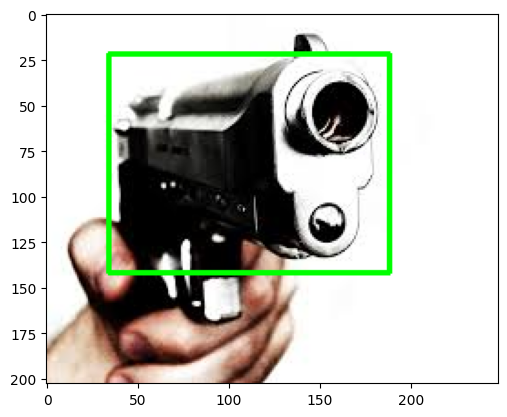

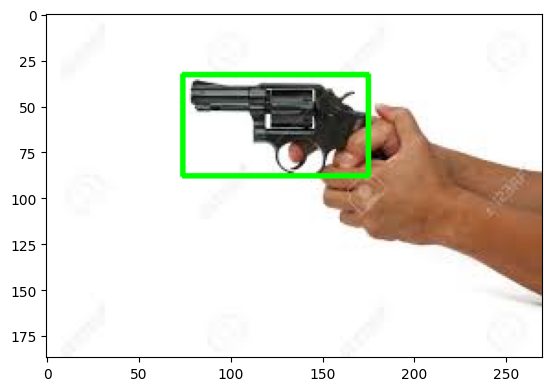

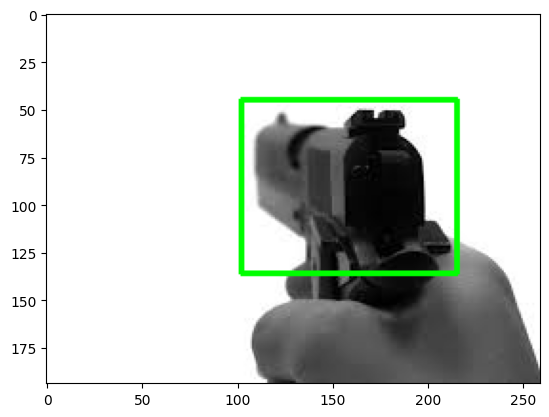

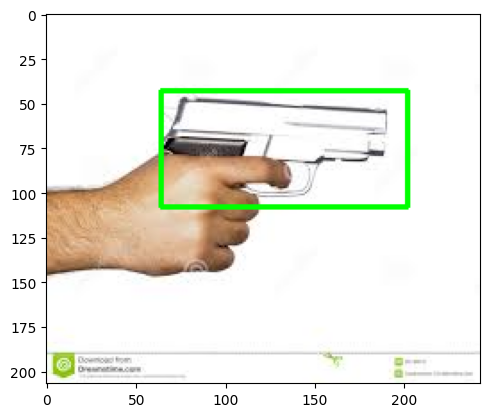

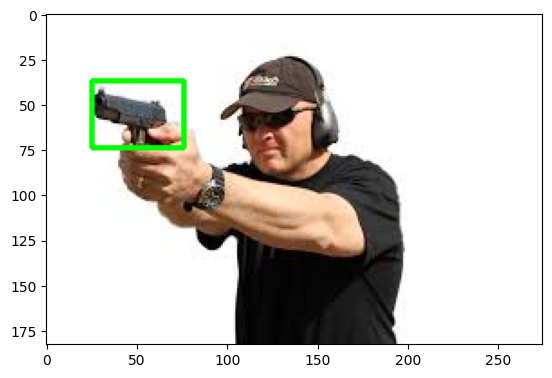

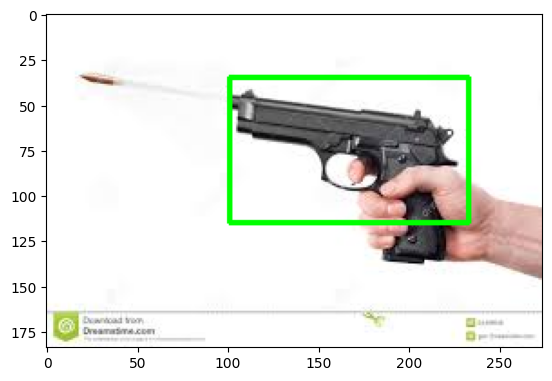

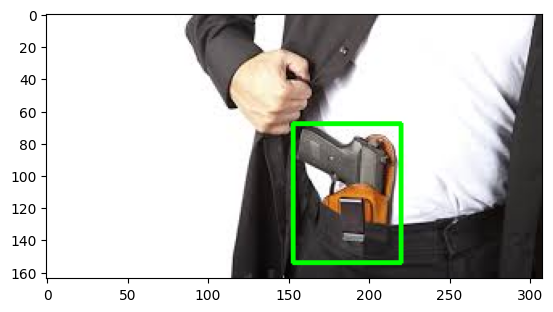

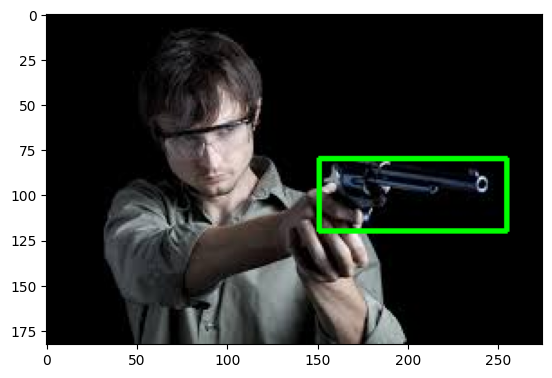

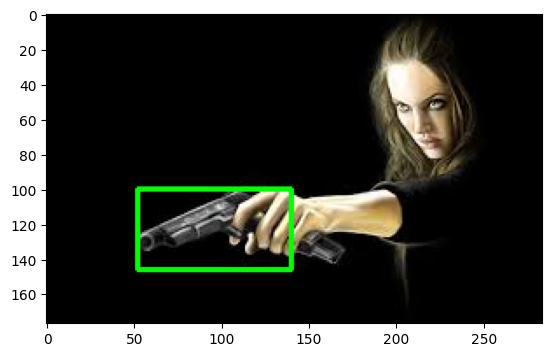

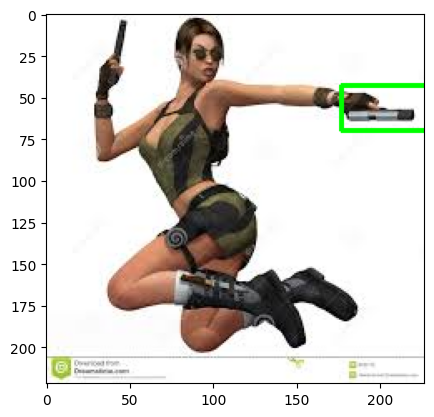

In [37]:
for i in range(weird_files.shape[0]):
    draw_bounding_box(weird_files[i])

---
### Wnioski
- Zbiór ten okazał się dobrym wyborem, posiada on wiele zdjęć o "wysokiej jakości".
- Nie wymaga on zbytniego czyszczenia, jeżeli chodzi o brakuje wartości czy anomalie.
- Przed trenowaniem modelu należy pamiętać o poprawnym załadowaniu danych (wiele broni na 1 zdjęciu).